In [1]:
import h5py
import tensorflow as tf
import torch
import torch.nn as nn
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('../..')))

from models._data import ChromatinDataset
from models._model import CBPLTrainer

2024-12-12 17:29:18.672110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-12 17:29:18.672164: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_chrs = ["chr2",
    "chr4",
    "chr5",
    "chr7",
    "chr9",
    "chr10",
    "chr11",
    "chr12",
    "chr13",
    "chr14",
    "chr15",
    "chr16",
    "chr17",
    "chr18",
    "chr19",
    "chr21",
    "chr22",
    "chrX",
    "chrY"]

In [3]:
config = {
    "peak_regions": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/Microglia_peak_set_2.bed",
    "nonpeak_regions": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/own_data/test.chr1.negatives.adjusted.bed",
    "genome_fasta": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/data/downloads/hg38.fa",
    "cts_bw_file": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/nd_Microglia_merge.bw",
    "negative_sampling_ratio": 0,
    "train_size": 0.6,
    "batch_size": 32,
    "filters": 512,
    "n_dil_layers": 8,
    "conv1_kernel_size": 21,
    "profile_kernel_size": 71,
    "dilation_kernel_size": 3,
    "input_seq_len": 2114,
    "out_pred_len": 1000,
    "dropout_rate": 0.0,
    "learning_rate": 0.001,
    "train_chrs": train_chrs,
    "valid_chrs": ["chr20"],
    "seq_focus_len": 500,
    "use_cpu": False,
    "alpha" : 1,
    "checkpoint_path": None,
    "flavor" : None,
    "project": "cbpl_new_microglia",
    "return_embeddings" : True,
    "jitter" : False,
    "jitter_scale" : 0.1
}



In [4]:
chrombpnet = tf.keras.models.load_model('/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/microglia_model.h5')


2024-12-12 17:31:31.900186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-12 17:31:31.902109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-12 17:31:31.903900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-12 17:31:31.905096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-12-12 17:31:31.913176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [5]:
from utils.data_utils import get_seq, get_cts
from utils.one_hot import dna_to_one_hot
import pyBigWig
import pyfaidx


In [6]:
genome = pyfaidx.Fasta("/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/data/downloads/hg38.fa")

In [7]:
bw = pyBigWig.open("/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/nd_Microglia_merge.bw")

In [13]:
correct = get_seq(genome,11,60251677,60251677,2114)
one_hot_correct = tf.expand_dims(tf.squeeze(dna_to_one_hot(correct),axis=1),axis=0)

In [31]:
def change_char(string, position, new_char):
  return string[:position] + new_char + string[position + 1:]


In [34]:
mutation = change_char(correct,1057,"T")
one_hot_mutated = tf.expand_dims(tf.squeeze(dna_to_one_hot(mutation),axis=1),axis=0)

In [16]:
output_correct=chrombpnet(one_hot_correct)

In [35]:
output_mutated=chrombpnet(one_hot_mutated)

In [21]:
import matplotlib.pyplot as plt 

In [26]:
np(output_correct[0])

TypeError: 'module' object is not callable

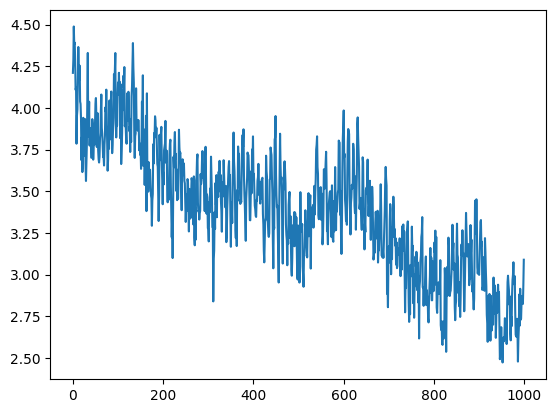

In [36]:
plt.plot(tf.squeeze(output_correct[0]))

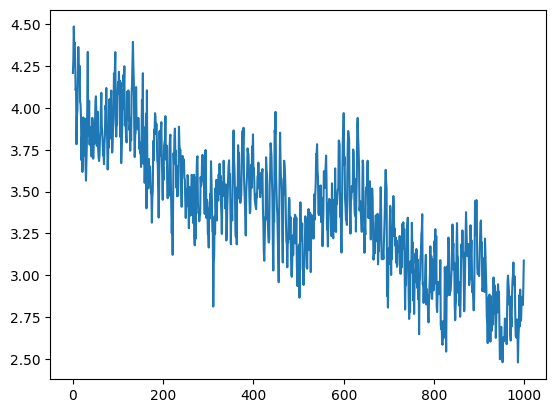

In [37]:
plt.plot(tf.squeeze(output_mutated[0]))

In [8]:
trainer =  CBPLTrainer(config,checkpoint_path='/wynton/home/corces/vishvak/pytorch_cbp/testing/cbpl_new_microglia/p4d4disj/checkpoints/cbpl-epoch=09-val_loss=0.00.ckpt')

Read in bed file of 151351 regions
Read in bed file of 16900 regions
Loaded 151351 peak regions and 0 non-peak regions
Loading model from checkpoint: /wynton/home/corces/vishvak/pytorch_cbp/testing/cbpl_new_microglia/p4d4disj/checkpoints/cbpl-epoch=09-val_loss=0.00.ckpt
cpu


/wynton/home/corces/vishvak/miniforge3/envs/chrombpnet/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [10]:
cbp_outputs = []
pytorch_outputs  = []
target_list = []


for batch in trainer.valid_dataloader:
    inputs,targets = batch
    pytorch_outputs.append(trainer.model.predict(inputs.to('cuda')))
    tf_input = tf.convert_to_tensor(inputs.numpy())
    tf_input=tf.transpose(tf_input, perm=[0, 2, 1])
    predictions = chrombpnet.predict(tf_input)
    cbp_outputs.append(predictions)
    target_list.append(targets)


In [18]:
import pickle
with open('pytorch_outputs.pckl', 'wb') as f:
    pickle.dump(pytorch_outputs, f)

In [19]:
with open('cbp_outputs.pckl', 'wb') as f:
    pickle.dump(cbp_outputs, f)

In [20]:
with open('targets.pckl', 'wb') as f:
    pickle.dump(target_list, f)

In [21]:
import scipy

In [22]:
import pickle
file = open('cbp_outputs.pckl', 'rb')
cbp_outputs = pickle.load(file)
file.close()

file = open('targets.pckl', 'rb')
target_list = pickle.load(file)
file.close()

file = open('pytorch_outputs.pckl', 'rb')
pytorch_outputs = pickle.load(file)
file.close()

In [23]:
total_count_pytorch = [inner_list[0] for inner_list in pytorch_outputs]
total_count_cbp = [inner_list[1] for inner_list in cbp_outputs]
total_count_target = [inner_list[0] for inner_list in target_list]


In [24]:
profile_pytorch = [inner_list[1] for inner_list in pytorch_outputs]
profile_cbp = [inner_list[0] for inner_list in cbp_outputs]
profile_target = [inner_list[1] for inner_list in target_list]

In [25]:
import scipy
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

cbp_correlations = []
pytorch_correlations = []
cbp_js_divergences = []
pytorch_js_divergences = []
cbp_kl_divergences = []
pytorch_kl_divergences = []
cbp_cosine_similarities = []
pytorch_cosine_similarities = []

for cbp, target, pytorch in zip(profile_cbp, profile_target, profile_pytorch):
    # Initialize lists to store metrics for each element
    element_cbp_correlations = []
    element_pytorch_correlations = []
    element_cbp_js_divergences = []
    element_pytorch_js_divergences = []
    element_cbp_kl_divergences = []
    element_pytorch_kl_divergences = []
    element_cbp_cosine_similarities = []
    element_pytorch_cosine_similarities = []
    
    # Iterate over corresponding elements in the profiles
    for cbp_element, target_element, pytorch_element in zip(cbp, target, pytorch):
        # Convert tensors to NumPy arrays
        cbp_array = cbp_element
        target_array = target_element.cpu().numpy()
        pytorch_array = pytorch_element.cpu().numpy()
        
        # Normalize arrays to make them valid probability distributions
        cbp_norm = cbp_array / np.sum(cbp_array + 1e-12)
        target_norm = target_array / np.sum(target_array + 1e-12)
        pytorch_norm = pytorch_array / np.sum(pytorch_array + 1e-12)
        
        # Compute Spearman correlation
        corr_cbp, _ = scipy.stats.spearmanr(target_array, cbp_array)
        element_cbp_correlations.append(corr_cbp)
        
        corr_pytorch, _ = scipy.stats.spearmanr(target_array, pytorch_array)
        element_pytorch_correlations.append(corr_pytorch)
        
        # Compute Jensen-Shannon Divergence
        js_cbp = jensenshannon(target_norm, cbp_norm)
        element_cbp_js_divergences.append(js_cbp)
        
        js_pytorch = jensenshannon(target_norm, pytorch_norm)
        element_pytorch_js_divergences.append(js_pytorch)
        
        # Compute KL Divergence
        kl_cbp = entropy(target_norm, cbp_norm)
        element_cbp_kl_divergences.append(kl_cbp)
        
        kl_pytorch = entropy(target_norm, pytorch_norm)
        element_pytorch_kl_divergences.append(kl_pytorch)
        
        # Compute Cosine Similarity
        cosine_cbp = 1 - scipy.spatial.distance.cosine(target_array, cbp_array)
        element_cbp_cosine_similarities.append(cosine_cbp)
        
        cosine_pytorch = 1 - scipy.spatial.distance.cosine(target_array, pytorch_array)
        element_pytorch_cosine_similarities.append(cosine_pytorch)
    
    # Flatten and compute means for each metric
    cbp_correlations.append(np.mean(element_cbp_correlations))
    pytorch_correlations.append(np.mean(element_pytorch_correlations))
    cbp_js_divergences.append(np.mean(element_cbp_js_divergences))
    pytorch_js_divergences.append(np.mean(element_pytorch_js_divergences))
    cbp_kl_divergences.append(np.mean(element_cbp_kl_divergences))
    pytorch_kl_divergences.append(np.mean(element_pytorch_kl_divergences))
    cbp_cosine_similarities.append(np.mean(element_cbp_cosine_similarities))
    pytorch_cosine_similarities.append(np.mean(element_pytorch_cosine_similarities))


<Axes: >

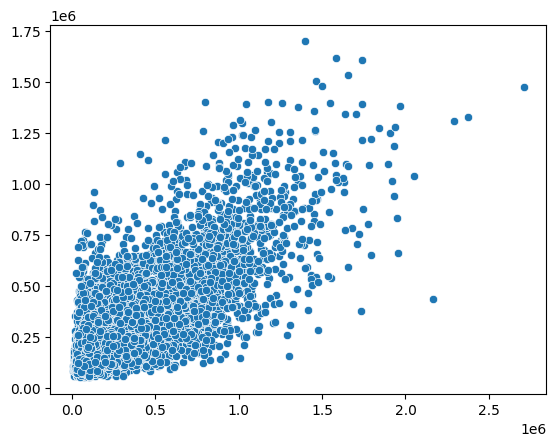

In [79]:
sns.scatterplot(x=concatenated_targets.sum(axis=1),y=concatenated_pytorch.sum(axis=1))

In [57]:
pytorch_cosine_similarities.shape

(454,)

In [61]:
profile_pytorch

[tensor([[ 60.7213,  61.7935,  62.7536,  ...,  55.1726,  55.3732,  54.3896],
         [183.1999, 181.4322, 180.1594,  ...,  95.4258,  94.9073,  95.4206],
         [296.0735, 296.4151, 293.8647,  ...,  75.5454,  74.9448,  74.0951],
         ...,
         [ 52.3008,  52.3567,  52.4872,  ...,  66.9825,  66.2785,  66.1463],
         [129.3997, 130.5859, 130.9510,  ...,  56.7272,  56.5480,  55.9708],
         [136.6712, 135.9205, 136.3416,  ..., 545.0092, 538.1130, 539.0558]],
        device='cuda:0'),
 tensor([[  82.1811,   82.6882,   81.9799,  ...,  470.3331,  471.4494,
           474.7292],
         [   0.0000,    0.0000,    0.0000,  ...,  112.9775,  113.3844,
           113.6212],
         [  90.3435,   91.0385,   91.0205,  ..., 1425.9147, 1441.3378,
          1460.5220],
         ...,
         [ 291.5435,  291.9918,  293.9937,  ...,  162.6217,  160.6189,
           159.4254],
         [ 303.3835,  301.3579,  302.3352,  ...,  936.3704,  949.6191,
           959.0683],
         [ 144.677

In [58]:
np.concatenate(profile_pytorch.numpy())

AttributeError: 'list' object has no attribute 'numpy'

In [55]:
len(profile_pytorch[1])

32

In [47]:
cbp_top5_indices

array([111, 302,  45, 386, 437])

In [51]:
cbp_top5_indices

array([111, 302,  45, 386, 437])

In [82]:
cos_sim.shape

(14519, 14519)

In [87]:
concatenated_pytorch.shape

(14519, 1000)

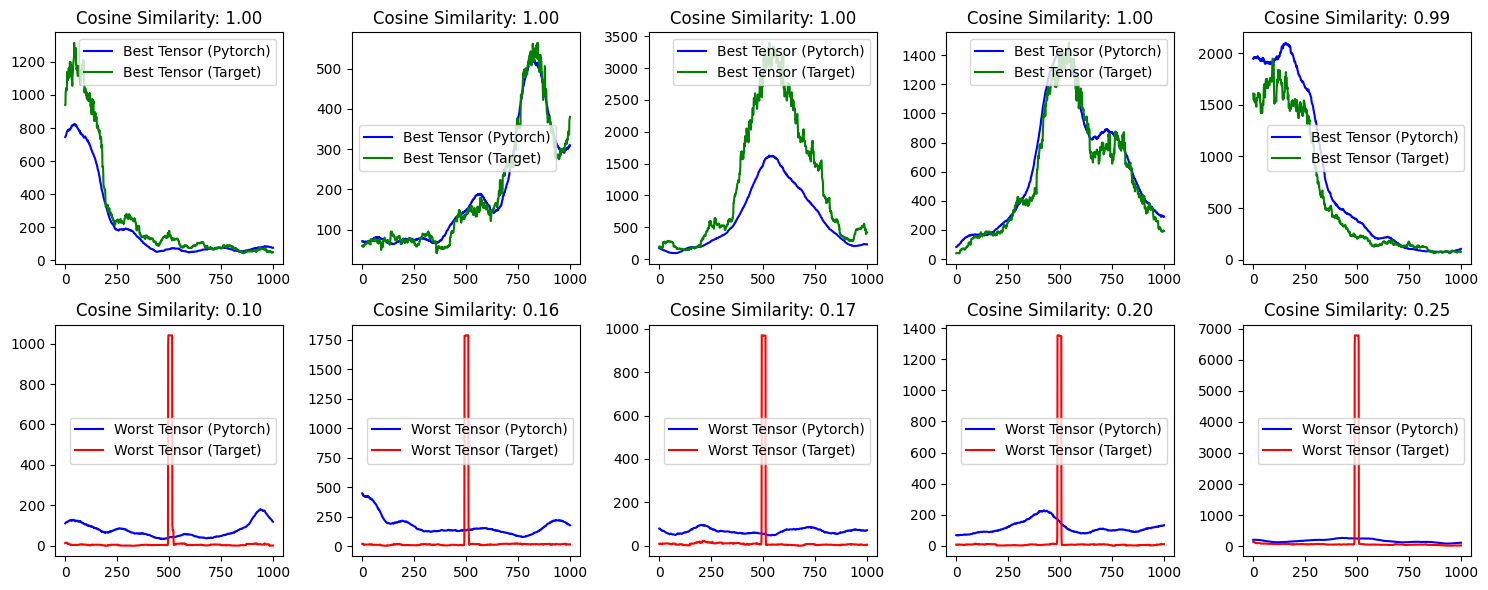

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Assuming concatenated_pytorch and concatenated_targets are already defined
# Calculate cosine similarities for corresponding pairs (i.e., same index in both)
cos_sim = [cosine_similarity(pytorch.reshape(1, -1), target.reshape(1, -1))[0][0]
           for pytorch, target in zip(concatenated_pytorch, concatenated_targets)]

# Convert the cosine similarities to a numpy array
cos_sim = np.array(cos_sim)

# Find the indices of the top 5 best and worst cosine similarities
top_5_best_idx = np.argsort(cos_sim)[-5:][::-1]  # Indices of top 5 best similarities
top_5_worst_idx = np.argsort(cos_sim)[:5]  # Indices of top 5 worst similarities

# Get the best and worst tensors based on these indices
best_tensors_pytorch = concatenated_pytorch[top_5_best_idx]
best_tensors_target = concatenated_targets[top_5_best_idx]
worst_tensors_pytorch = concatenated_pytorch[top_5_worst_idx]
worst_tensors_target = concatenated_targets[top_5_worst_idx]
best_cos_sim = cos_sim[top_5_best_idx]
worst_cos_sim = cos_sim[top_5_worst_idx]

# Plot the top 5 best and worst cosine similarities
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plot best tensors
for i in range(5):
    axs[0, i].plot(best_tensors_pytorch[i], label='Best Tensor (Pytorch)', color='blue')
    axs[0, i].plot(best_tensors_target[i], label='Best Tensor (Target)', color='green')
    axs[0, i].set_title(f'Cosine Similarity: {best_cos_sim[i]:.2f}')
    axs[0, i].legend()

# Plot worst tensors
for i in range(5):
    axs[1, i].plot(worst_tensors_pytorch[i], label='Worst Tensor (Pytorch)', color='blue')
    axs[1, i].plot(worst_tensors_target[i], label='Worst Tensor (Target)', color='red')
    axs[1, i].set_title(f'Cosine Similarity: {worst_cos_sim[i]:.2f}')
    axs[1, i].legend()

plt.tight_layout()
plt.show()


<Axes: ylabel='Proportion'>

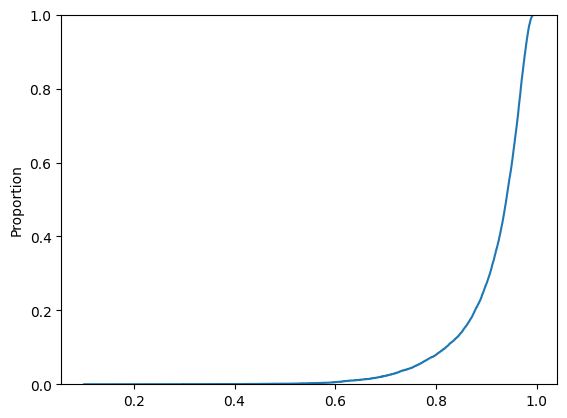

In [85]:
sns.ecdfplot(cos_sim)

In [ ]:

# Plot the top 5 best and worst cosine similarities
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Plot best tensors
for i in range(5):
    axs[0, i].plot(best_tensors_pytorch[i], label='Best Tensor (Pytorch)', color='blue')
    axs[0, i].plot(best_tensors_target[i], label='Best Tensor (Target)', color='green')
    axs[0, i].set_title(f'Cosine Similarity: {best_cos_sim[i]:.2f}')
    axs[0, i].legend()

# Plot worst tensors
for i in range(5):
    axs[1, i].plot(worst_tensors_pytorch[i], label='Worst Tensor (Pytorch)', color='blue')
    axs[1, i].plot(worst_tensors_target[i], label='Worst Tensor (Target)', color='red')
    axs[1, i].set_title(f'Cosine Similarity: {worst_cos_sim[i]:.2f}')
    axs[1, i].legend()

plt.tight_layout()
plt.show()


In [ ]:
np.concatenate()

In [ ]:

# Plot for CBP profiles (actual data)
plot_profiles_for_top_bottom(
    profile_cbp, 
    cbp_top5_indices, 
    cbp_bottom5_indices, 
    "CBP Profiles"
)

# Plot for PyTorch profiles (actual data)
plot_profiles_for_top_bottom(
    profile_pytorch, 
    pytorch_top5_indices, 
    pytorch_bottom5_indices, 
    "PyTorch Profiles"
)


In [37]:
np.mean(cbp_js_divergences)

0.19555526557932007

In [38]:
np.mean(pytorch_js_divergences)

0.1517266688535279

In [36]:
np.mean(pytorch_js_divergences)

0.1517266688535279

In [13]:
import matplotlib.pyplot as plt
import scipy.stats

# Initialize empty lists to hold all flattened values
cbp_total_count_flat_all = []
targets_flat_all = []
pytorch_flat_all = []

# Flatten across all pairs in the lists
for cbp, targets, pytorch in zip(total_count_cbp, total_count_target,total_count_pytorch):
    cbp_total_count_flat_all.extend(cbp.flatten())  # Append flattened arrays to the list
    targets_flat_all.extend(targets.numpy().flatten())  # Append flattened tensors to the list
    pytorch_flat_all.extend(pytorch.cpu().numpy().flatten()) 

cbp_total_count_flat_all = np.array(cbp_total_count_flat_all)
targets_flat_all = np.array(targets_flat_all)
pytorch_flat_all = np.array(pytorch_flat_all)


In [14]:
def plot_scatter_with_r2(x, y, ax, label_x, label_y):
    # Compute Pearson correlation
    corr, _ = scipy.stats.spearmanr(x, y)
    r2 = corr
    
    # Create scatter plot
    ax.scatter(x, y, alpha=0.5)
    
    # Plot the correlation line
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', linestyle='--')

    # Set labels and title
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.set_title(f'r² = {r2:.3f}')
    


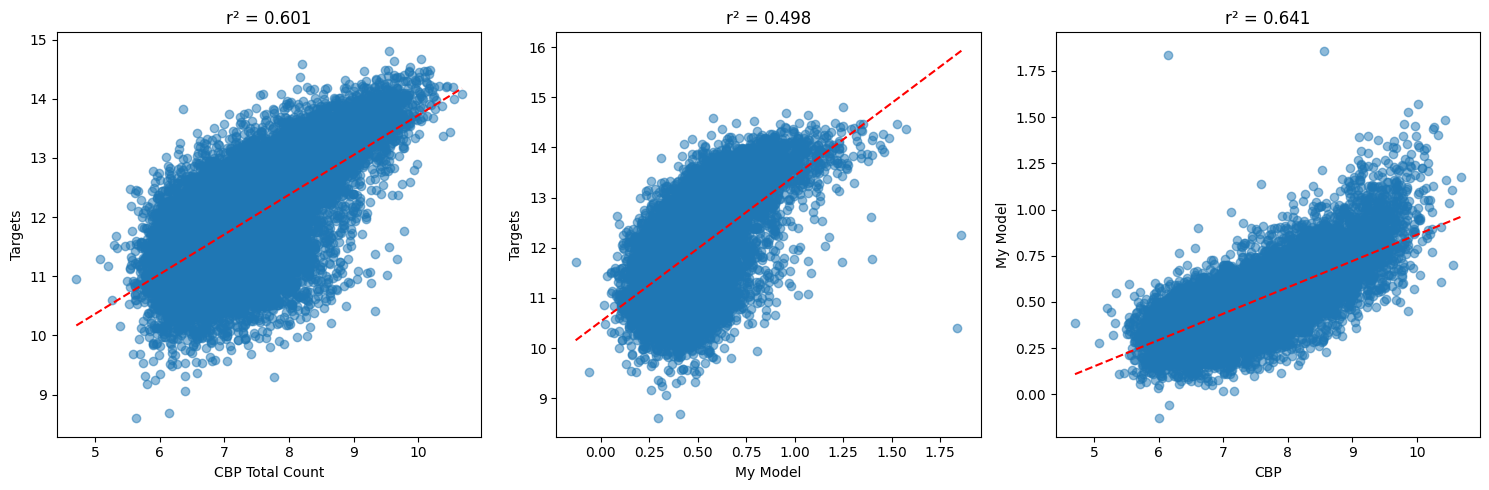

In [32]:
# Create a figure with subplots for each pair
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter for each pair of arrays
plot_scatter_with_r2(cbp_total_count_flat_all,targets_flat_all, axes[0], 'CBP Total Count', 'Targets')
plot_scatter_with_r2(pytorch_flat_all, targets_flat_all, axes[1], 'My Model', 'Targets')
plot_scatter_with_r2(cbp_total_count_flat_all, pytorch_flat_all, axes[2], 'CBP', 'My Model')

# Show the plots
plt.tight_layout()
plt.show()

<Axes: ylabel='Count'>

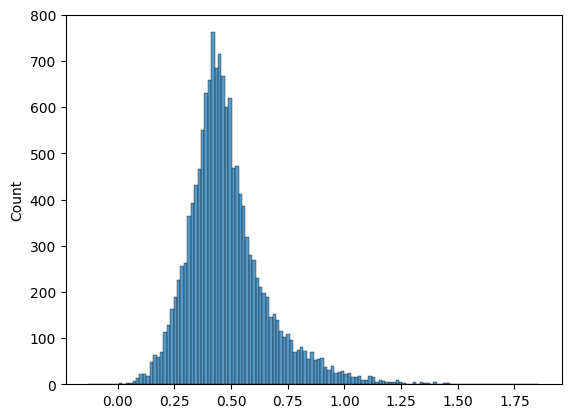

In [29]:
import seaborn as sns
import numpy as np
sns.histplot(pytorch_flat_all)

In [34]:
np.expm1(np.log(1e6 + 1))

999999.9999999997

<Axes: ylabel='Count'>

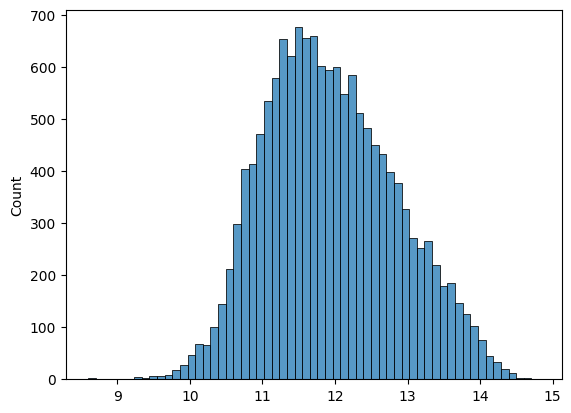

In [28]:
sns.histplot((targets_flat_all))

<Axes: ylabel='Count'>

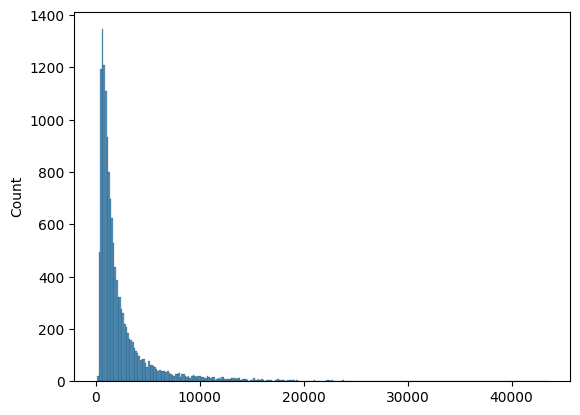

In [25]:
sns.histplot(np.expm1(cbp_total_count_flat_all))

In [19]:
import matplotlib.pyplot as plt
import scipy.stats

# Initialize empty lists to hold all flattened values
arrays_flat_all = []
tensor_array_flat_all = []

# Flatten across all pairs in the lists
for arrays, tensors in zip(total_count_pytorch, total_count_target):
    arrays_flat_all.extend(arrays.flatten())  # Append flattened arrays to the list
    tensor_array_flat_all.extend(tensors.numpy().flatten())  # Append flattened tensors to the list

# Convert lists to numpy arrays for easier computation
arrays_flat_all = np.array(arrays_flat_all)
tensor_array_flat_all = np.array(tensor_array_flat_all)

# Compute linear regression parameters
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(arrays_flat_all, tensor_array_flat_all)

# Generate regression line
regression_line = slope * arrays_flat_all + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(arrays_flat_all, tensor_array_flat_all, alpha=0.5, s=10, label='Data points')
plt.plot(arrays_flat_all, regression_line, color='red', label=f'Regression line (R={r_value:.2f})')
plt.xlabel('Flattened arrays (x)')
plt.ylabel('Flattened tensors (y)')
plt.title('Scatter Plot with Regression Line (Flattened across entire list)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Horizontal reference line
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Vertical reference line
plt.legend()
plt.grid(alpha=0.3)
plt.show()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [13]:
np.mean(total_count_correlations)

0.6525249640371389

In [34]:
cbp_outputs[0][1]

array([[7.325824 ],
       [7.084136 ],
       [5.825772 ],
       [9.2791395],
       [9.615878 ],
       [7.3718853],
       [9.228523 ],
       [6.3948245],
       [6.977394 ],
       [8.941177 ],
       [6.592784 ],
       [6.24013  ],
       [6.64201  ],
       [6.830545 ],
       [7.548041 ],
       [7.960613 ],
       [8.164963 ],
       [6.6631722],
       [7.186769 ],
       [6.006334 ],
       [7.301787 ],
       [8.118916 ],
       [6.6786795],
       [6.4047055],
       [8.657536 ],
       [6.6046586],
       [8.150584 ],
       [7.572649 ],
       [6.8496776],
       [6.7405667],
       [7.241837 ],
       [9.421427 ]], dtype=float32)

In [36]:
target_list[0][0]

tensor([[12.2241],
        [12.3323],
        [12.1945],
        [11.9315],
        [10.7240],
        [12.3794],
        [10.8337],
        [12.0433],
        [11.5107],
        [14.0406],
        [11.8057],
        [12.7858],
        [ 9.8691],
        [12.7918],
        [10.9310],
        [11.3741],
        [12.0004],
        [13.5961],
        [11.8265],
        [11.1264],
        [12.0155],
        [11.2092],
        [12.0551],
        [12.4721],
        [12.4870],
        [12.2118],
        [12.7550],
        [10.6452],
        [12.6383],
        [11.6742],
        [11.4432],
        [13.8237]])

In [38]:
scipy.stats.pearsonr(cbp_outputs[0][1],target_list[0][0])

ValueError: shapes (32,1) and (32,1) not aligned: 1 (dim 1) != 32 (dim 0)

In [12]:
cbp_outputs[0][1] * np.expm1(cbp_outputs[0][0])

array([[  677.6998  ,   622.2949  ,   537.4961  , ...,   366.95718 ,
          477.51346 ,   506.2719  ],
       [  273.32956 ,   239.27838 ,   242.00792 , ...,   692.3912  ,
          790.6485  ,   889.7854  ],
       [  102.59722 ,   121.063545,   135.47209 , ...,   223.46265 ,
          226.23009 ,   284.5448  ],
       ...,
       [  186.16284 ,   200.04364 ,   198.00212 , ...,   617.58514 ,
          636.378   ,   521.05334 ],
       [ 1138.1594  ,   944.4837  ,   948.43964 , ...,   144.09798 ,
          155.50084 ,   135.50453 ],
       [ 1835.1411  ,  3385.6533  ,  1215.3094  , ..., 13515.946   ,
        13921.426   , 11904.1     ]], dtype=float32)

In [7]:
tf_input

<tf.Tensor: shape=(32, 4, 2114), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 1., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 1.],
        [1., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 1., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 1.],
        [0., 0., 1., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 1., 1., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ...,

In [8]:
inputs = inputs.to("cuda")

In [9]:
outputs = trainer.model.forward(inputs,return_embeddings=True)

In [13]:
outputs[2]["after_dilated_convs"].shape

torch.Size([32, 512, 1074])

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [22]:
def crop_center(embeddings, target_length=500):
    current_length = embeddings.shape[2]
    
    # Calculate how many elements to remove from each side
    total_remove = current_length - target_length
    remove_from_start = total_remove // 2
    remove_from_end = total_remove - remove_from_start
    
    # Crop equally from both sides
    cropped_embeddings = embeddings[:, :, remove_from_start:-remove_from_end]
    
    print(f"Original shape: {embeddings.shape}")
    print(f"Cropped shape: {cropped_embeddings.shape}")
    
    return cropped_embeddings

In [23]:
def process_embeddings(embeddings):
    # Crop the last dimension to 500
    cropped_embeddings = crop_center(embeddings,500)
    print("Cropped embedding shape:", cropped_embeddings.shape)
    
    # Reshape for PCA (flatten spatial dimensions)
    # From [32, 512, 500] to [32, 512*500]
    flat_embeddings = cropped_embeddings.reshape(embeddings.shape[0], -1).cpu().detach().numpy()
    
    # Perform PCA
    pca = PCA(n_components=2)  # Reduce to 2D for visualization
    pca_result = pca.fit_transform(flat_embeddings)
    
    # Plot PCA results
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    plt.title('PCA of Embeddings')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.tight_layout()
    plt.show()
    
    # Optional: Print explained variance
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    
    return pca_result, pca

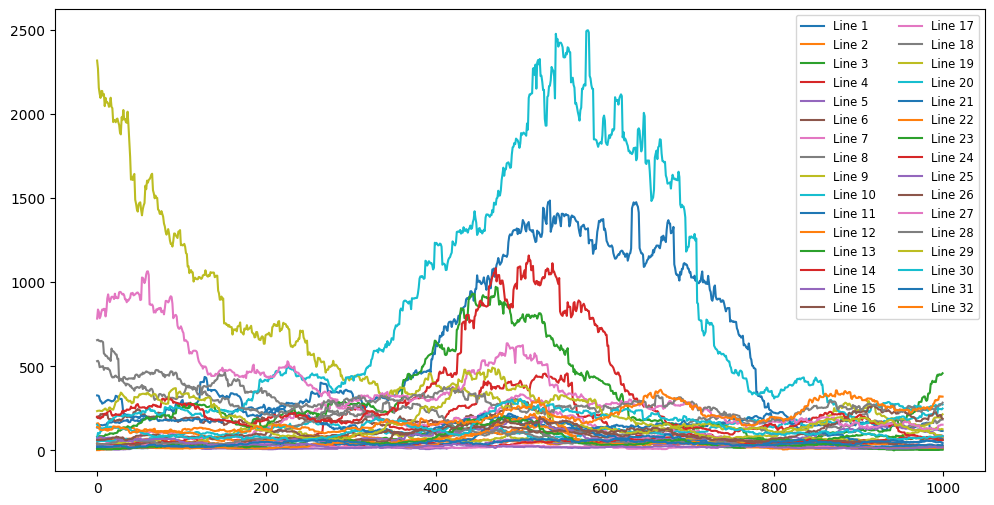

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6)) 
for i in range(targets[1].shape[0]):
    plt.plot(targets[1][i].numpy(), label=f'Line {i+1}')  # Convert tensor row to numpy for plotting
plt.legend(loc="upper right", fontsize="small", ncol=2)  # Show legend for all lines
plt.show()

Original shape: torch.Size([32, 512, 1074])
Cropped shape: torch.Size([32, 512, 500])
Cropped embedding shape: torch.Size([32, 512, 500])


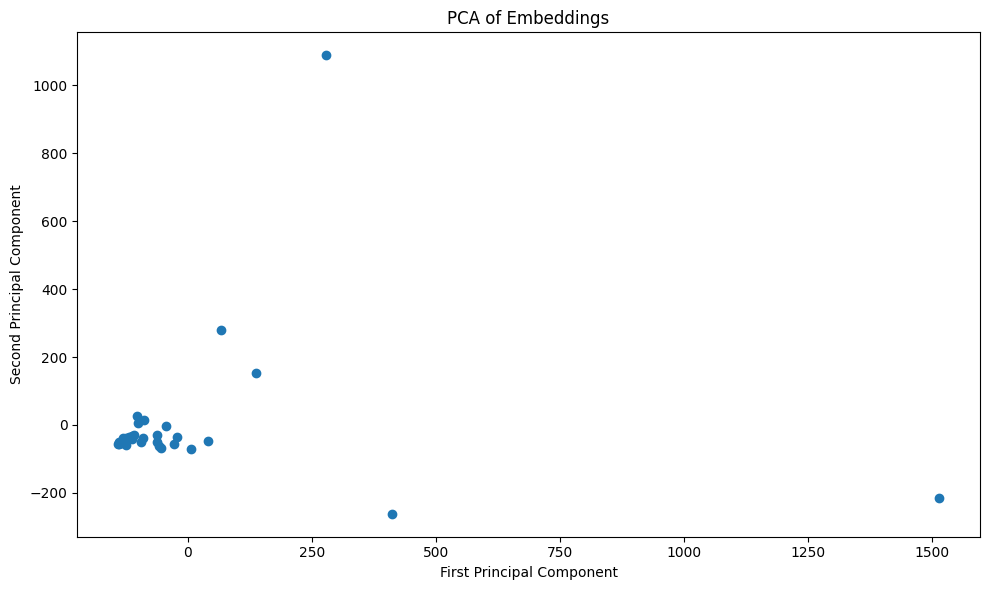

Explained variance ratio: [0.32722425 0.16805474]


(array([[ 278.26306  , 1088.0613   ],
        [-101.789024 ,   27.036057 ],
        [-118.20066  ,  -36.221367 ],
        [ -62.595943 ,  -30.397682 ],
        [-132.71182  ,  -53.690525 ],
        [ -95.05595  ,  -50.514584 ],
        [ -54.41076  ,  -66.91973  ],
        [-124.46352  ,  -59.92627  ],
        [-124.4638   ,  -38.03175  ],
        [-113.23989  ,  -31.458126 ],
        [-138.66496  ,  -50.479576 ],
        [ -44.988148 ,   -1.6722387],
        [  66.06792  ,  278.3342   ],
        [-140.44652  ,  -54.779606 ],
        [ -89.06548  ,   13.87737  ],
        [-100.85378  ,    6.357848 ],
        [ -91.40024  ,  -37.99626  ],
        [  39.596622 ,  -48.491676 ],
        [   5.4291897,  -71.82508  ],
        [1513.4116   , -214.64478  ],
        [ -22.862944 ,  -35.190926 ],
        [-130.25581  ,  -38.892296 ],
        [-138.10965  ,  -57.224888 ],
        [ 137.07022  ,  153.76178  ],
        [-121.77528  ,  -40.249043 ],
        [-109.3947   ,  -28.42107  ],
        [ 41

In [24]:
process_embeddings(outputs[2]["after_dilated_convs"])

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def standardize_embeddings(embeddings):
    # Crop the embeddings first
    cropped_embeddings = crop_center(embeddings, target_length=500)
    
    # Flatten spatial dimensions
    flat_embeddings = cropped_embeddings.reshape(cropped_embeddings.shape[0], -1)
    
    # Z-score standardization
    standardized = (flat_embeddings - flat_embeddings.mean(dim=0)) / flat_embeddings.std(dim=0)
    
    return standardized

def compute_standardized_distances(embeddings):
    # Standardize embeddings
    standardized_embeddings = standardize_embeddings(embeddings).cpu().numpy()
    
    # Compute pairwise distances on standardized embeddings
    distances = pdist(standardized_embeddings, metric='euclidean')
    square_distances = squareform(distances)
    
    # Visualize
    plt.figure(figsize=(12, 10))
    sns.heatmap(square_distances, cmap='viridis', 
                cbar_kws={'label': 'Standardized Euclidean Distance'})
    plt.title('Pairwise Standardized Embedding Distances')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    plt.tight_layout()
    plt.show()
    
    return square_distances

Original shape: torch.Size([32, 512, 1074])
Cropped shape: torch.Size([32, 512, 500])


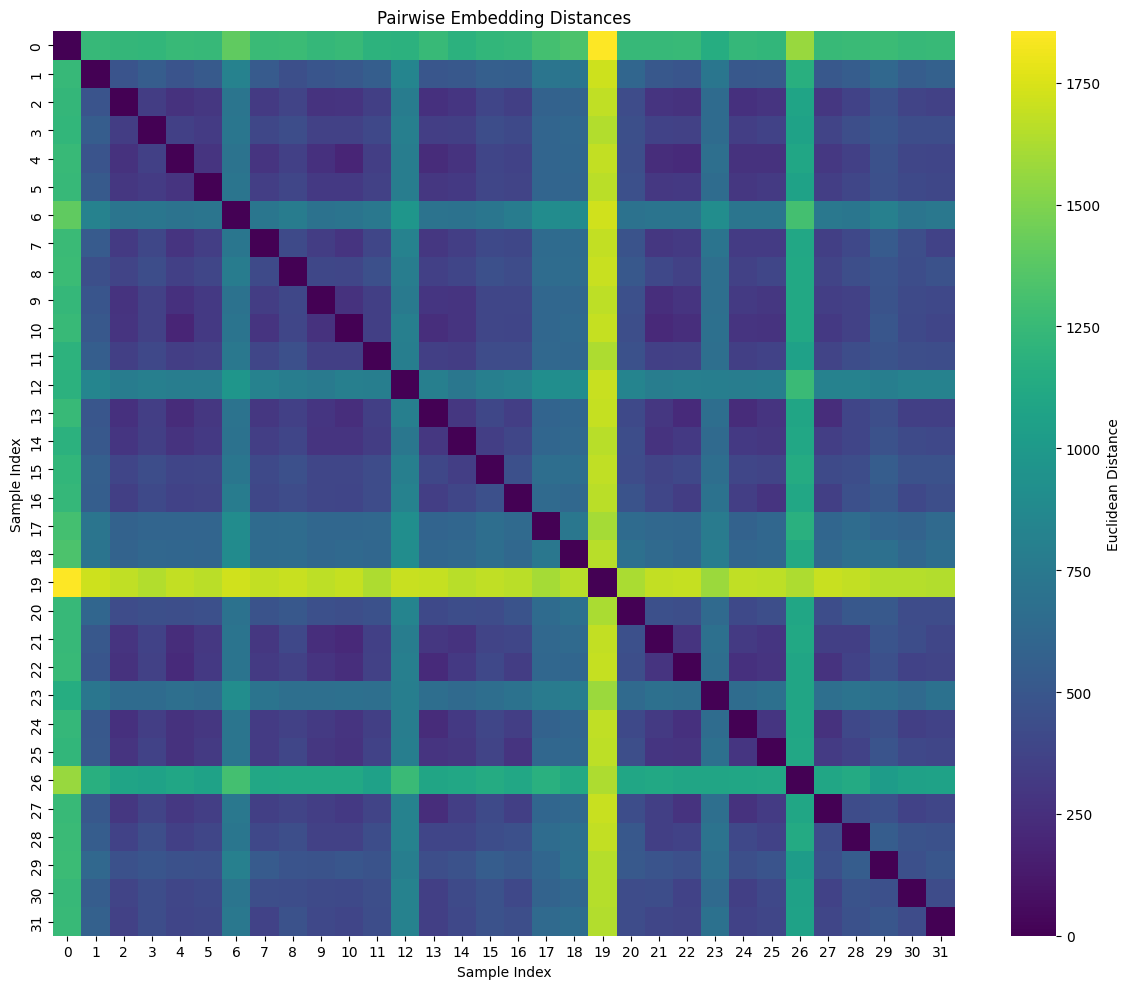

array([[   0.        , 1241.75631931, 1231.20336953, ..., 1268.32024783,
        1243.50518776, 1252.94587228],
       [1241.75631931,    0.        ,  481.94682585, ...,  620.12890667,
         541.1814304 ,  568.93299419],
       [1231.20336953,  481.94682585,    0.        , ...,  457.02883578,
         372.64873339,  360.81889842],
       ...,
       [1268.32024783,  620.12890667,  457.02883578, ...,    0.        ,
         452.03737648,  492.89489141],
       [1243.50518776,  541.1814304 ,  372.64873339, ...,  452.03737648,
           0.        ,  421.13551466],
       [1252.94587228,  568.93299419,  360.81889842, ...,  492.89489141,
         421.13551466,    0.        ]])

In [36]:
compute_pairwise_distances(outputs[2]["after_dilated_convs"])